In [1]:
from pathlib import Path

import pandas
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Required by bert_preprocess_model
from official.nlp import optimization  # to create AdamW optimizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from data import load_datasets

DATA_PATH = Path("../data")
data = load_datasets(DATA_PATH)

X_train = data["labeled.tsv"]
X_test = data["test.tsv"]
X_unlabeled = data["unlabeled.tsv"]

In [2]:
encoder = LabelEncoder()
encoder.fit(X_train.category)

def transform_category(x: pandas.Series) -> tf.Tensor:
    y_true = encoder.fit_transform(x)
    return tf.keras.utils.to_categorical(y_true)

batch_size = 32
ds = (
    tf
        .data
        .Dataset
        .from_tensor_slices((X_train.message, transform_category(X_train.category)))
        .batch(batch_size)
)
ds_val = (
    tf
        .data
        .Dataset
        .from_tensor_slices((X_test.message, transform_category(X_test.category)))
        .batch(batch_size)
)

classes = encoder.classes_

2021-11-04 20:32:40.458066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-04 20:32:40.505165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-11-04 20:32:40.505181: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-04 20:32:40.506478: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [3]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
bert_model = hub.KerasLayer(tfhub_handle_encoder)

2021-11-04 20:32:42.334875: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [4]:
# Source: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
text_test = X_train.message.iloc[:4]
text_preprocessed = bert_preprocess_model(text_test)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f"{bert_results.keys()}")
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
dict_keys(['encoder_outputs', 'default', 'sequence_output', 'pooled_output'])
Sequence Outputs Shape:(4, 128, 512)


In [5]:
def classifier_factory():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(len(classes), activation=None, name='classifier')(net)
    net = tf.nn.softmax(net)
    return tf.keras.Model(text_input, net)

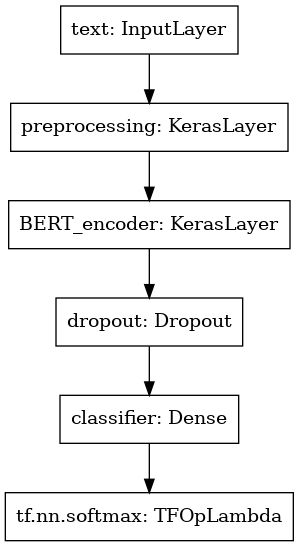

In [6]:
tf.keras.utils.plot_model(classifier_factory())

In [7]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [8]:
epochs = 42
steps_per_epoch = ds.cardinality().numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)

In [9]:
classifier_model = classifier_factory()
classifier_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [10]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(
    x=ds,
    epochs=epochs
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/42
4/4 [==============================] - 9s 1s/step - loss: 1.8149 - categorical_accuracy: 0.1193
Epoch 2/42
4/4 [==============================] - 6s 1s/step - loss: 1.7893 - categorical_accuracy: 0.1651

In [11]:
y_pred = classifier_model.predict(ds_val)
y_pred = tf.argmax(y_pred, axis=-1)
print(classification_report(X_test.category, encoder.inverse_transform(y_pred)))

              precision    recall  f1-score   support

        ABBR       0.86      0.67      0.75         9
        DESC       0.59      0.97      0.73       138
        ENTY       0.81      0.40      0.54        94
         HUM       0.75      0.89      0.82        65
         LOC       0.89      0.83      0.86        81
         NUM       0.76      0.44      0.56       113

    accuracy                           0.71       500
   macro avg       0.78      0.70      0.71       500
weighted avg       0.74      0.71      0.69       500

